In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants as spc
from matplotlib.widgets import Button # , Slider
import threading
import sys
import time
import os
from scipy import interpolate
from scipy import signal
import matplotlib
from GDD import PicoScope as ps  # module for pico_scope
from GDD import ZabberVoiceCoil as stage # module to operate stage 
import traceback
import logging
from IPython.display import display
%matplotlib notebook


## To Check if there is an error in the code

In [2]:
logging.basicConfig( filename="errors.log",
                     filemode='w',
                     level=logging.DEBUG,
                     format= '%(asctime)s - %(levelname)s - %(message)s',
                   )

## Start communication with stage

In [5]:
s = stage.ZabberVoiceCoil('COM3')

ID OK:@01 0 OK IDLE NI 50419


In [6]:
s.sin(1000,100)  

b'@01 0 OK BUSY -- 0\r\n'
b'@01 0 OK BUSY -- 0\r\n'


In [45]:
s.sin_stop()
s.close()

b'@01 0 RJ IDLE NI BADCOMMAND\r\n'
Communication closed...


## Start communication with Picoscope

In [3]:
class ProcessGDD(object): #TODO live class
    """
    Class used for a adding live update to a figure. Run ´%matplotlib notebook´ in jupyter notebook
    for optimal operation of this class. This adds

    Attributes
    ----------
    rp: `object`
        This object is a Oscilloscope object (initially from Red Pitaya, class daq.devices_new.RPdevice()).
    rpplot: `object`
        This object is a fastplot object (class daq.FastPlotNotebook())."""
    
    def __init__(self):
        
        #initialize values
        N = int(3e5)
        R = 1.0e6
        D_time = 1/R
        T = N/R
        self.timeS = sp.linspace(0,T-D_time,N)
        self.signal_HeNe = sp.zeros(N)
        self.signal_SC = sp.zeros(N)
        self.wl_laser = 633e-9  #in m
        
    ###############################################
        self.N_test =int(N/500)
        self.time_plot = self.timeS[::self.N_test]
        self.HeNe_plot = sp.zeros_like(self.time_plot)
        self.SC_plot = sp.zeros_like(self.time_plot)
        
    ##################################################    
        
        self.N = N
        self.N_FFT = int(2**16)
        self.n_daq_smp = N
        self.ps = ps.DAQ_parallel_channels(Samples_per_channel= self.n_daq_smp)

    def clear(self):
     
        self.HeNe_plot = sp.zeros_like(self.time_plot)
        self.SC_plot = sp.zeros_like(self.time_plot)
        
    def update_data(self):
        self.timeS,data = self.ps.DAQ_read()
#         data = sp.load('new_data_19march.npy')
#         self.timeS = data[:,0]
        self.signal_HeNe = data[:,0]
        self.signal_SC = data[:,1]
        
        
#         self.timeS = timeS
#         self.signal_HeNe = signal_HeNe
#         self.signal_SC = signal_SC
        
#         N=len(self.timeS)
#         R=1.0e6
#         D_time = 1/R
#         T = N/R
        ## ###################################################new change
        
        self.time_plot = self.timeS[::self.N_test]
        self.HeNe_plot = sp.zeros_like(self.time_plot)
        for i in sp.arange(0, len(self.time_plot)-1, 2):
            self.HeNe_plot[i]=self.signal_HeNe[(i*self.N_test):(i*self.N_test+2*self.N_test)].max()
        for i in sp.arange(1, len(self.time_plot), 2):
            self.HeNe_plot[i]=self.signal_HeNe[(i*self.N_test):(i*self.N_test+2*self.N_test)].min()
        self.HeNe_plot *= 1e-3
        
        self.SC_plot = sp.zeros_like(self.time_plot)
        for i in sp.arange(0, len(self.time_plot)-1, 2):
            self.SC_plot[i]=self.signal_SC[(i*self.N_test):(i*self.N_test+2*self.N_test)].max()
        for i in sp.arange(1, len(self.time_plot), 2):
            self.SC_plot[i]=self.signal_SC[(i*self.N_test):(i*self.N_test+2*self.N_test)].min()
        self.SC_plot *=1e-3
        #####################################################    
#         plt.figure()
#         plt.plot(self.time_plot,self.HeNe_plot)
#         plt.plot(self.time_plot,self.SC_plot)
        #####################################################
    
    def close(self):
        self.ps.DAQ_close()
       
        # TODO close daq
        

In [25]:

# p = ProcessGDD()
# p.update_data()

# plt.figure()
# plt.plot(p.time_plot,p.HeNe_plot)
# plt.plot(p.time_plot,p.SC_plot)


In [26]:
# p.close()
# wl_mask = (p.wl > 950e-9) * (p.wl < 1150e-9) 
# data = sp.transpose([p.wl[wl_mask], p.spectra_avg[wl_mask], p.GDD_phase_avg[wl_mask]])
# sp.savetxt('test.txt',data ,header='wl (nm), spectrum (a.u.), gdd (fs^2)', delimiter=', ' , newline='\r\n')

In [27]:
# plt.figure()
# plt.plot(p.time_plot,p.HeNe_plot)
# p.close()

In [4]:
class FastPlotNotebook(object):
   
    def __init__(self,p):
        %matplotlib notebook
        self.p = p
        self.i = 0
        fig, ax1 = plt.subplots(1,figsize=(15/2.54,15/2.54))
        self.fig = fig
        self.ax1 = ax1
       
        #####################################################
        timeS = self.p.time_plot
        signal_HeNe = self.p.HeNe_plot
        signal_SC = self.p.SC_plot
        
        #####################################################
        self.ax1.set_title('HeNe, IR')
        
        self.ax1.set_xlim(0,timeS[-1])
        self.ax1.set_ylim(-0.2,10)
        self.ax1.set_xlabel('Time (s)')
        self.ax1.set_ylabel('Signal (a.u.)')
        
        
       
        self.HeNe_pl, = self.ax1.plot(timeS,signal_HeNe)
        self.SC_pl, = self.ax1.plot(timeS,signal_SC)
        
        self.fig.tight_layout()
        self.fig.subplots_adjust(wspace = 0.7,bottom = 0.2)
    
    def update_plot(self):
        self.i +=1
        self.ax1.set_title('HeNe, IR:{}'.format(self.i))
        timeS = self.p.time_plot
        signal_HeNe = self.p.HeNe_plot
        signal_SC = self.p.SC_plot
       
        self.HeNe_pl.set_ydata(signal_HeNe)
        self.SC_pl.set_ydata(signal_SC)
        self.fig.canvas.draw()

   

In [5]:
class LiveOsci(object): #TODO live class
   
    def __init__(self):  #(self#,pico_scope,plot_obj)
        self.process_inst = ProcessGDD()
        self.plot_obj = FastPlotNotebook(self.process_inst)
        global loopBool
        loopBool = False
        self.getbuttons()
    
    def getbuttons(self):
        axcolor = 'lightblue'
        ttax = plt.axes([0.05, 0.01, 0.15, 0.06])
        self.buttontt = Button(ttax, 'Single sweep', color=axcolor, hovercolor='0.975')
        self.buttontt.on_clicked(self._update_trace)
        
        runax = plt.axes([0.35, 0.01, 0.05, 0.06])
        self.buttonrun = Button(runax, 'Run', color=axcolor, hovercolor='0.975')
        self.buttonrun.on_clicked(self._looping_pre) #the run command has to be started throgh a thread with a global condition in order to interupt it
        
        stopax = plt.axes([0.425, 0.01, 0.05, 0.06])
        self.buttonstop = Button(stopax, 'Stop', color=axcolor, hovercolor='0.975')
        self.buttonstop.on_clicked(self._stop_meas)
        
        clearax = plt.axes([0.525, 0.01, 0.05, 0.06])
        self.buttonclear = Button(clearax, 'clear', color=axcolor, hovercolor='0.975')
        self.buttonclear.on_clicked(self._clear_button)
       
        # TODO buttons for clear and save
        
    def _looping_pre(self, event): #this is new
        global loopBool
        if (loopBool == False): #this is needed to prevent problems when the runbutton is started twice
            thread=threading.Thread(target=self._run_meas,args=(event,))
            thread.daemon=True   #might or might not be needed
            thread.start()

    # *********** Button callbacks ********************
    def _run_meas(self,event):
        global loopBool
        loopBool = True
        try:
            while loopBool:
                self.process_inst.update_data()
                self.plot_obj.update_plot()
        except Exception as e:
            logging.exception(e, exc_info=True)
        
    def _update_trace(self,event):
        self.process_inst.update_data()
        self.plot_obj.update_plot()
        
    def _stop_meas(self, event):
        global loopBool
        loopBool = False
        self.process_inst.close()
        
    def _clear_button(self, event):
        global loopBool
        loopBool = False
        self.process_inst.clear()
        self.plot_obj.update_plot()
        

<IPython.core.display.Javascript object>


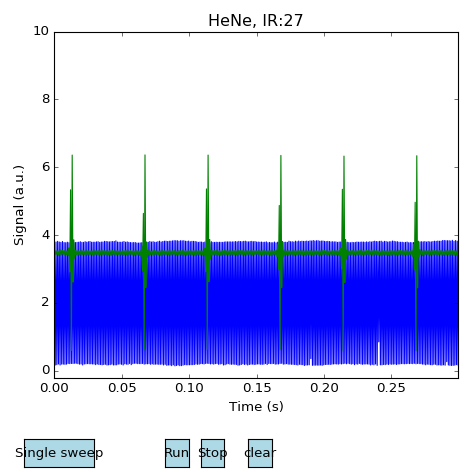

In [6]:

liveplt = LiveOsci() #rp,rpplot


In [7]:
liveplt.process_inst.close()

In [7]:
rp.DAQ_close()

NameError: name 'rp' is not defined

In [71]:
class TestClass(object):
    
    def __init__(self):
        self.variable = 1    # public variable
        self._private_var = 5
        
    def _private_function(self):
        return self._private_var
    
    def public_function(self):
        return self._private_function()

In [72]:
inst1 = TestClass()

In [73]:
inst2 = TestClass()

In [74]:
inst1.public_function()

5

In [84]:
a = inst1.variable

In [85]:
a += 3

In [86]:
inst1.variable

1